In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Cell 1: Imports & GPU Check
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# التأكد من الـ GPU
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Ready: {gpus[0].name}")
else:
    print("Warning: Running on CPU")

2025-12-13 01:39:28.114136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765582768.131240   41866 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765582768.135874   41866 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 01:39:28.151864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow Version: 2.18.1
✅ GPU Ready: /physical_device:GPU:0


In [ ]:
# Cell 2: Configurations & Label Map Creation
# ================= CONFIG (عدل المسارات دي حسب جهازك) =================

# 1. المسار الرئيسي اللي جواه فولدرات الكلمات (اللي جواه cry, dog, ...)
LOCAL_DATA_DIR = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/1st_prototype_processed_2"

# 2. مسار أي ملف CSV فيه الـ 100 كلمة (عشان نعمل منه القاموس)
ANY_CSV_WITH_WORDS = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/mini_dataset.csv"

# 3. مسارات ملفات التقسيم (حتى لو المسارات جواهم غلط، الكود هيصلحها)
TRAIN_CSV_PATH = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_train.csv"
VAL_CSV_PATH   = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_val.csv"

# 4. مكان حفظ القاموس (هنحفظه جنبك)
LABEL_MAP_OUTPUT = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/label_map.json"

# ================= الخطوة 0: إنشاء ملف القاموس (لو مش موجود) =================
if not os.path.exists(LABEL_MAP_OUTPUT):
    print("Label map not found. Generating it now from CSV...")
    if os.path.exists(ANY_CSV_WITH_WORDS):
        df = pd.read_csv(ANY_CSV_WITH_WORDS)
        unique_words = sorted(df['word'].unique())
        label_map = {word: i for i, word in enumerate(unique_words)}
        
        with open(LABEL_MAP_OUTPUT, 'w') as f:
            json.dump(label_map, f, indent=4)
        print(f"Created label_map.json with {len(label_map)} classes.")
    else:
        print("Error: CSV file not found to generate labels.")
else:
    print("Label map already exists.")

# تحميل القاموس
with open(LABEL_MAP_OUTPUT, 'r') as f:
    label_map = json.load(f)
print(f"Loaded {len(label_map)} classes.")

✅ Label map already exists.
Loaded 100 classes.


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, csv_path, base_data_dir, batch_size=32, num_classes=100, shuffle=True, label_map=None):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.label_map = label_map
        
        # قراءة الـ CSV
        self.df = pd.read_csv(csv_path)
        
        # ================= التعديل السحري: تحميل كل الداتا في الرام =================
        print(f"Pre-loading data from {csv_path} into RAM... (This might take a minute)")
        self.X_data = []
        self.y_data = []
        
        valid_indices = [] # هنحتفظ بس بالفيديوهات السليمة
        
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            word = row['word']
            # استخراج اسم الملف
            col_name = 'full_path' if 'full_path' in row else 'videos'
            video_name = os.path.basename(row[col_name])
            npy_name = os.path.splitext(video_name)[0] + '.npy'
            npy_path = os.path.join(base_data_dir, word, npy_name)
            
            if os.path.exists(npy_path):
                try:
                    data = np.load(npy_path)
                    if data.shape == (50, 198): 
                        self.X_data.append(data)
                        self.y_data.append(label_map[word])
                        valid_indices.append(i)
                except: pass
        
        # تحويلهم لمصفوفات Numpy مرة واحدة
        self.X_data = np.array(self.X_data, dtype=np.float32)
        self.y_data = np.array(self.y_data, dtype=np.int32)
        
        # عدد العينات الصالحة
        self.n_samples = len(self.X_data)
        self.indexes = np.arange(self.n_samples)
        
        print(f"Loaded {self.n_samples} samples into RAM successfully!")
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, index):
        # هنا بقا مش بنقرأ من الهارد، بنجيب من الرام علطول (سريع جداً)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X_batch = self.X_data[indexes]
        y_batch = self.y_data[indexes]
        
        # One-hot encoding
        y_encoded = tf.keras.utils.to_categorical(y_batch, num_classes=self.num_classes)
        return X_batch, y_encoded

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

GPUs Available: 1
⏳ Preparing Data Generators...
🔄 Pre-loading data from /mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_train.csv into RAM... (This might take a minute)
✅ Loaded 8916 samples into RAM successfully!
🔄 Pre-loading data from /mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_val.csv into RAM... (This might take a minute)
✅ Loaded 1115 samples into RAM successfully!
🏗️ Building Model...


I0000 00:00:1765582966.472476   41866 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2564 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/abdulrahman-mohamed-rizk/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔥 Starting Training...
Epoch 1/60


/home/abdulrahman-mohamed-rizk/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1765582978.227618   43188 cuda_dnn.cc:529] Loaded cuDNN version 90101


277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.0124 - loss: 4.8440
Epoch 1: val_categorical_accuracy improved from -inf to 0.03309, saving model to best_bilstm_local.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - categorical_accuracy: 0.0124 - loss: 4.8430 - val_categorical_accuracy: 0.0331 - val_loss: 4.4334 - learning_rate: 0.0010
Epoch 2/60
276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0396 - loss: 4.3333
Epoch 2: val_categorical_accuracy improved from 0.03309 to 0.07353, saving model to best_bilstm_local.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - categorical_accuracy: 0.0397 - loss: 4.3323 - val_categorical_accuracy: 0.0735 - val_loss: 4.0353 - learning_rate: 0.0010
Epoch 3/60
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0693 - loss: 3.9890
Epoch 3: val_categorical_accuracy improved from 0.07353 to 0.11213, saving model to best_bilstm_local.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - categorical_accu

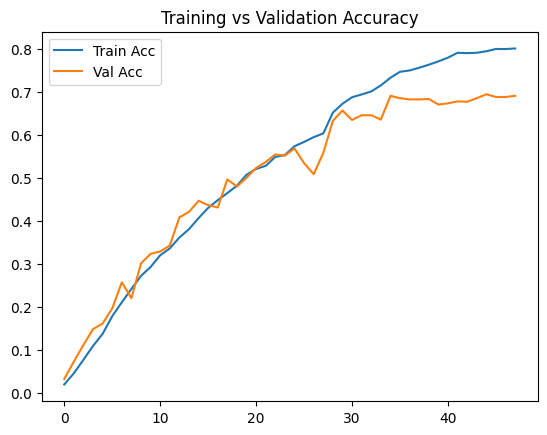

In [ ]:
# Cell 3: Model Definition & Training
def build_bilstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

# التنفيذ
if __name__ == "__main__":
    # التأكد من الـ GPU
    print("GPUs Available:", len(tf.config.list_physical_devices('GPU')))
    
    NUM_CLASSES = len(label_map)
    BATCH_SIZE = 32
    EPOCHS = 60 # زودنا شوية عشان BiLSTM بيحتاج وقت يتعلم

    print("Preparing Data Generators...")
    train_gen = DataGenerator(TRAIN_CSV_PATH, LOCAL_DATA_DIR, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, label_map=label_map)
    val_gen   = DataGenerator(VAL_CSV_PATH, LOCAL_DATA_DIR, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, label_map=label_map, shuffle=False)

    print("Building Model...")
    model = build_bilstm_model((50, 198), NUM_CLASSES)
    
    callbacks = [
        ModelCheckpoint('best_bilstm_local.keras', save_best_only=True, monitor='val_categorical_accuracy', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    print("Starting Training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    
  
    plt.plot(history.history['categorical_accuracy'], label='Train Acc')
    plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
import time
import numpy as np
import tensorflow as tf

# 1. تحميل الموديل المحفوظ
# (تأكد من الاسم الصحيح للموديل المحفوظ عندك)
model_path = 'best_bilstm_local.keras' 
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except:
    print("Error loading model. Using current 'model' variable from memory.")

# 2. إنشاء بيانات وهمية للتجربة (Dummy Input)
# Shape: (1, 50 frames, 198 features)
dummy_input = np.random.rand(1, 50, 198).astype(np.float32)

# 3. تسخين الـ GPU (Warm-up)
# أول عملية دايماً بطيئة، فبنعملها عشان منحسبهاش
print("Warming up GPU...")
for _ in range(10):
    model.predict(dummy_input, verbose=0)

# 4. اختبار السرعة الحقيقي
print("Measuring Latency...")
start_time = time.time()
iterations = 100

for _ in range(iterations):
    model.predict(dummy_input, verbose=0)

end_time = time.time()

# 5. الحسابات
total_time = end_time - start_time
avg_time_per_video = (total_time / iterations) * 1000 # تحويل لـ مللي ثانية

print("\n" + "="*30)
print(f"REPORT: BiLSTM Performance")
print("="*30)
print(f"Average Inference Time: {avg_time_per_video:.2f} ms")
print(f"Total Parameters: {model.count_params():,}")

# التقييم
if avg_time_per_video < 30:
    print("Status: EXCELLENT for Real-time (Very Fast)")
elif avg_time_per_video < 100:
    print("Status: ACCEPTABLE (Might have slight lag)")
else:
    print("Status: TOO SLOW for Live Meeting")
print("="*30)

✅ Model loaded successfully.
🔥 Warming up GPU...
⏱️ Measuring Latency...

📊 REPORT: BiLSTM Performance
🚀 Average Inference Time: 64.61 ms
🧠 Total Parameters: 596,260
⚠️ Status: ACCEPTABLE (Might have slight lag)


In [12]:
!pip install scikit-learn seaborn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 1.1 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]earn]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. التوقع على داتا الاختبار (Val)
# (تأكد إن val_gen لسه موجود في الذاكرة)
print("Analyzing Errors...")
y_pred_prob = model.predict(val_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
# y_true = val_gen.classes  # لو الـ Generator مش بيحفظ الـ classes، هنحتاج نجيبها بطريقة تانية
# الطريقة الأضمن لجلب الـ True Labels من الـ Generator بالترتيب:
y_true = []
for i in range(len(val_gen)):
    _, batch_y = val_gen[i]
    y_true.extend(np.argmax(batch_y, axis=1))
y_true = np.array(y_true)

# تأكد إن الأطوال متطابقة (ممكن يحصل فرق بسيط بسبب الـ batches)
limit = min(len(y_true), len(y_pred))
y_true = y_true[:limit]
y_pred = y_pred[:limit]

# 2. حساب الدقة لكل كلمة
cm = confusion_matrix(y_true, y_pred)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# 3. طباعة "أغبى" 10 كلمات الموديل مش فاهمهم
# (هنستخدم label_map المعكوسة)
inv_label_map = {v: k for k, v in label_map.items()}
sorted_indices = np.argsort(accuracy_per_class)

print("Worst 10 Performing Words:")
for i in range(10):
    idx = sorted_indices[i]
    word = inv_label_map[idx]
    acc = accuracy_per_class[idx] * 100
    print(f"{i+1}. {word}: {acc:.1f}% accuracy")

🔍 Analyzing Errors...
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📉 Worst 10 Performing Words:
1. oil: 0.0% accuracy
2. plenty: 12.5% accuracy
3. break: 20.0% accuracy
4. stamp: 27.3% accuracy
5. hold: 30.0% accuracy
6. go: 30.0% accuracy
7. catch: 31.2% accuracy
8. move: 33.3% accuracy
9. cool: 40.0% accuracy
10. spread: 44.4% accuracy
